#Library and Dependecies

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Data preparation

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [5]:
%cd /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


In [6]:
!kaggle datasets download -d roopahegde/cryptocurrency-timeseries-2020

 75% 17.0M/22.7M [00:00<00:00, 50.1MB/s]
100% 22.7M/22.7M [00:00<00:00, 66.7MB/s]


In [7]:
!unzip \*.zip && rm *.zip

Archive:  cryptocurrency-timeseries-2020.zip
  inflating: gemini_BTCUSD_2020_1min.csv  
  inflating: gemini_ETHUSD_2020_1min.csv  
  inflating: gemini_LTCUSD_2020_1min.csv  


In [29]:
df = pd.read_csv('gemini_BTCUSD_2020_1min.csv')
df

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1.618880e+12,4/20/2021 0:02,BTCUSD,55717.47,55723.00,55541.69,55541.69,2.406734
1,1.618880e+12,4/20/2021 0:01,BTCUSD,55768.94,55849.82,55711.74,55717.47,0.573458
2,1.618880e+12,4/20/2021 0:00,BTCUSD,55691.79,55793.15,55691.79,55768.94,3.309904
3,1.618880e+12,4/19/2021 23:59,BTCUSD,55777.86,55777.86,55677.92,55691.79,0.684934
4,1.618880e+12,4/19/2021 23:58,BTCUSD,55803.50,55823.88,55773.08,55777.86,0.477225
...,...,...,...,...,...,...,...,...
658060,1.577840e+12,1/1/2020 0:04,BTCUSD,7163.60,7163.60,7163.00,7163.00,1.751844
658061,1.577840e+12,1/1/2020 0:03,BTCUSD,7163.00,7163.60,7163.00,7163.60,0.002706
658062,1.577840e+12,1/1/2020 0:02,BTCUSD,7163.30,7164.22,7163.00,7163.00,0.063904
658063,1.577840e+12,1/1/2020 0:01,BTCUSD,7163.30,7164.23,7163.30,7163.30,0.002646


#Data preprocessing

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)
df

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
658064,1.577840e+12,2020-01-01 00:00:00,BTCUSD,7165.90,7170.79,7163.30,7163.30,0.007931
658063,1.577840e+12,2020-01-01 00:01:00,BTCUSD,7163.30,7164.23,7163.30,7163.30,0.002646
658062,1.577840e+12,2020-01-01 00:02:00,BTCUSD,7163.30,7164.22,7163.00,7163.00,0.063904
658061,1.577840e+12,2020-01-01 00:03:00,BTCUSD,7163.00,7163.60,7163.00,7163.60,0.002706
658060,1.577840e+12,2020-01-01 00:04:00,BTCUSD,7163.60,7163.60,7163.00,7163.00,1.751844
...,...,...,...,...,...,...,...,...
4,1.618880e+12,2021-04-19 23:58:00,BTCUSD,55803.50,55823.88,55773.08,55777.86,0.477225
3,1.618880e+12,2021-04-19 23:59:00,BTCUSD,55777.86,55777.86,55677.92,55691.79,0.684934
2,1.618880e+12,2021-04-20 00:00:00,BTCUSD,55691.79,55793.15,55691.79,55768.94,3.309904
1,1.618880e+12,2021-04-20 00:01:00,BTCUSD,55768.94,55849.82,55711.74,55717.47,0.573458


In [8]:
df.isnull().sum()

Unix Timestamp    0
Date              0
Symbol            0
Open              0
High              0
Low               0
Close             0
Volume            0
dtype: int64

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [23]:
train, val = train_test_split(df.iloc[:-3, 3:], test_size=0.2, shuffle=False)
scaler = MinMaxScaler()
train = scaler.fit_transform(train)[:, 0]
val = scaler.transform(val)[:, 0]
train = windowed_dataset(train, window_size=60, batch_size=120, shuffle_buffer=1000)
val = windowed_dataset(val, window_size=60, batch_size=120, shuffle_buffer=1000)

#Model

In [26]:
model = Sequential([
    Bidirectional(LSTM(60, return_sequences=True)),
    Dropout(0.2),
    LSTM(60),
    Dense(30, activation="relu"),
    Dense(10, activation="relu"),
    Dense(1)
])

optimizer = SGD(learning_rate=1e-04, momentum=0.9)
model.compile(
    optimizer = optimizer, 
    loss = Huber(),
    metrics = ['mae']
)

In [27]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=2, 
    restore_best_weights=True
    )

In [28]:
history = model.fit(
    train, 
    epochs = 10,
    verbose = 1,
    batch_size=120,
    validation_data=val,
    callbacks= [early_stopping]
)

Epoch 1/10
4387/4387 [==============================] - 136s 30ms/step - loss: 0.0021 - mae: 0.0409 - val_loss: 0.1011 - val_mae: 0.3990
Epoch 2/10
4387/4387 [==============================] - 126s 29ms/step - loss: 0.0028 - mae: 0.0384 - val_loss: 0.0759 - val_mae: 0.3408
Epoch 3/10
4387/4387 [==============================] - 130s 30ms/step - loss: 0.0020 - mae: 0.0309 - val_loss: 0.0618 - val_mae: 0.3060
Epoch 4/10
4387/4387 [==============================] - 128s 29ms/step - loss: 0.0014 - mae: 0.0247 - val_loss: 0.0523 - val_mae: 0.2805
Epoch 5/10
4387/4387 [==============================] - 125s 28ms/step - loss: 8.8193e-04 - mae: 0.0193 - val_loss: 0.0453 - val_mae: 0.2599
Epoch 6/10
4387/4387 [==============================] - 126s 29ms/step - loss: 5.4399e-04 - mae: 0.0150 - val_loss: 0.0399 - val_mae: 0.2428
Epoch 7/10
4387/4387 [==============================] - 128s 29ms/step - loss: 3.2593e-04 - mae: 0.0117 - val_loss: 0.0357 - val_mae: 0.2288
Epoch 8/10
4387/4387 [=======

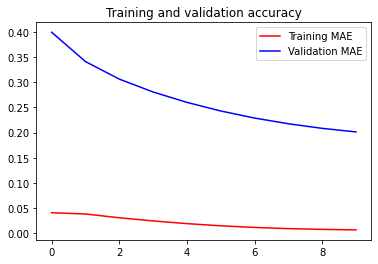

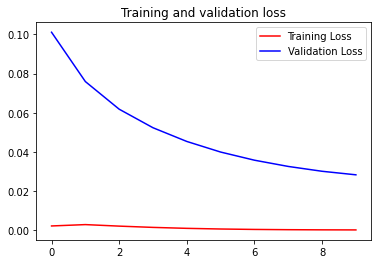

In [31]:
%matplotlib inline
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'r', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()